In [13]:
#imports

import numpy as np

import matplotlib.pyplot as plt

#import qmcpy as qp

import time

import collections.abc

from multiprocessing import Pool

from multiprocessing import Process

from argon_param import *


import geofunc2 as g2





In [14]:
# point of emission

multiple = 4 

x0 = 80#v*multiple+ed

y0 = Ly/2+ed

z0 = Lz/2+ed


# detector device center position

dev_x1 = ed

dev_y1 = Ly/2+ed

dev_z1 = Lz/2+ed


In [15]:
#geometric things

def solid_angle_on_axis(side1,side2,dist):
    
    return 4*np.arctan((side1*side2/(4*dist**2))/np.sqrt(1+(side1/(2*dist))**2+(side2/(2*dist))**2))


def solid_angle(x0,y0,z0, l1=l, l2=l, dev_x1 = dev_x1, dev_y1 = dev_y1, dev_z1 = dev_z1): # divided by 4pi
    
    A= dev_y1-y0-l1
    
    B= dev_z1-z0-l2
    
    d = np.abs(x0-dev_x1)
    
    angle = (solid_angle_on_axis(2*np.abs(A+2*l1),2*np.abs(B+2*l2),d) - np.sign(A)*solid_angle_on_axis(2*np.abs(A),2*np.abs(B+2*l2),d) - np.sign(B)*solid_angle_on_axis(2*np.abs(A+2*l1),2*np.abs(B),d) + np.sign(A)*np.sign(B)*solid_angle_on_axis(2*np.abs(A),2*np.abs(B),d))/(16*np.pi)

    return angle


def distance(x, y, z, x0, y0, z0):
    return np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)


def semi_major(t):
    return v*t/2

def semi_minor_sqr(t, x, y, z, x0, y0, z0):
    return (v**2*t**2 - distance( x, y, z, x0, y0, z0)**2)/4

def eccentricity(t, x, y, z, x0, y0, z0):
    return distance(x, y, z, x0, y0, z0)/(v*t)

def radial_param(a, e, phi):
    return (a*(1-e**2))/(1-e*np.cos(phi))

def vol_ellipsoid(t, x, y, z, x0, y0, z0):
    return 4/3*np.pi*semi_major(t)*semi_minor_sqr(t, x, y, z, x0, y0, z0)

def normal_cont(n1, n2, n3, v1, v2, v3):
    if n1*v1+n2*v2+n3*v3 >0:
        value = (n1*v1+n2*v2+n3*v3)/np.sqrt(v1**2+v2**2+v3**2)
    else:
        value = 0
    return value


def directions(x, y, z, x0, y0, z0):
    dir1 = np.array([x0-x,y0-y,z0-z])/distance(x, y, z, x0, y0, z0)
    if dir1[1]!= 0 or dir1[0] != 0:
        dir2 = np.array([-dir1[1],dir1[0],0])/np.sqrt(dir1[1]**2+dir1[0]**2)
    else:
        dir2 = np.array([1,0,0])
    dir3 = np.cross(dir1,dir2)
    return np.transpose(np.array([dir1,dir2,dir3]))



def average_outward(t, x, y, z, x0, y0, z0, n1, n2, n3):
    alphaa = directions(x, y, z, x0, y0, z0)
    aux = lambda r, theta, phi: r**2*np.sin(phi)*normal_cont(n1, n2, n3,
                                                             -alphaa[0,0]*r*np.cos(phi) -alphaa[0,1]*r*np.sin(phi)*np.sin(theta)-alphaa[0,2]*r*np.sin(phi)*np.cos(theta),
                                                            -alphaa[1,0]*r*np.cos(phi) -alphaa[1,1]*r*np.sin(phi)*np.sin(theta)-alphaa[1,2]*r*np.sin(phi)*np.cos(theta),
                                                            -alphaa[2,0]*r*np.cos(phi) -alphaa[2,1]*r*np.sin(phi)*np.sin(theta)-alphaa[2,2]*r*np.sin(phi)*np.cos(theta))
    value = integrate.tplquad(aux, 0,np.pi, 0,2*np.pi, 0, lambda phi, theta: radial_param(semi_major(t), eccentricity(t, x, y, z, x0, y0, z0), phi))[0]
    return value/vol_ellipsoid(t, x, y, z, x0, y0, z0)


def average_outward2(t, x, y, z, x0, y0, z0, n1, n2, n3):
    normal = np.linalg.inv(directions(x, y, z, x0, y0, z0)).dot(np.array([n1, n2, n3]))
    e = eccentricity(t, x, y, z, x0, y0, z0)
    a = v*t/2
    aux = lambda theta: (
    0.5 * (normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2) / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
                                                                                         - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))**2
    -np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2) / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
                                                                                         - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))
    )
    value = -(integrate.quad(aux, 0,2*np.pi)[0] + 2*np.pi/(1-e) - np.pi/(1-e)**2)*a**3*(1-e**2)**3/(3*e**2)
    return value/vol_ellipsoid(t, x, y, z, x0, y0, z0)



def average_outward3(t, x, y, z, x0, y0, z0, n1, n2, n3):
    normal = (directions(x, y, z, x0, y0, z0)).dot(np.array([n1, n2, n3]))
    e = eccentricity(t, x, y, z, x0, y0, z0)
    a = v*t/2
    
    aux = lambda theta: (
        a**3*(1-e**2)**3/(3*e**2)*normal[0]*(
    -0.5 * (normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))**2
    +np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta))))
    -(a**3*(1-e**2)**3/(3*e**3)*(
    np.log(1-e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta))
           /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)))
    +2*(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2))
        /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
          - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))
    -(1-e**2)/2*(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
          - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))**2)
    *(normal[1]*np.cos(theta)+normal[2]*np.sin(theta)))    
                        )
    
    thing = (np.pi/(1-e)**2 - 2*np.pi/(1-e))*normal[0]*a**3*(1-e**2)**3/(3*e**2)
    if v*t - distance(0, y, z, x0, y0, z0)> 0:
        value = integrate.quad(aux, 0, 2*np.pi, epsabs = 0.001)[0] + thing
    else:
        value = 0
    return (value)/vol_ellipsoid(t, x, y, z, x0, y0, z0)


def average_inward3(t, x, y, z, x0, y0, z0, n1, n2, n3):
    normal = np.linalg.inv(directions(x, y, z, x0, y0, z0)).dot(np.array([n1, n2, n3]))
    e = eccentricity(t, x, y, z, x0, y0, z0)
    a = v*t/2

    aux = lambda theta: (
        a**3*(1-e**2)**3/(3*e**2)*normal[0]*(
    +0.5 * (normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))**2
    -np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        / (np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta))))
    +(a**3*(1-e**2)**3/(3*e**3)*(
    np.log(1-e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta))
           /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)))
    +2*(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2))
        /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
          - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))
    -(1-e**2)/2*(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
        /(np.sqrt(normal[0]**2 + (normal[1] * np.cos(theta) + normal[2] * np.sin(theta))**2)
          - e*(normal[1] * np.cos(theta) + normal[2] * np.sin(theta)))**2)
    *(normal[1]*np.cos(theta)+normal[2]*np.sin(theta)))    
                        )
    
    thing = -(np.pi/(1+e)**2 - 2*np.pi/(1+e))*normal[0]*a**3*(1-e**2)**3/(3*e**2)
    
    if v*t - distance(x, y, z, x0, y0, z0)> 0:
        value = integrate.quad(aux, 0, 2*np.pi, epsabs = 0.001)[0] + thing
    else:
        value = 0
    
    return (value)/vol_ellipsoid(t, x, y, z, x0, y0, z0)


In [4]:
'''
t=x0/v + 1
x=0
y=2*y0
z=z0
d = g2.distance(x, y, z, x0, y0, z0)
semi_major = g2.semi_major(t)
semi_minor_sqr = g2.semi_minor_sqr(t, x, y, z, x0, y0, z0)
vol_ellipsoid = g2.vol_ellipsoid(t, x, y, z, x0, y0, z0)
normal_cos = g2.normal_cos(1, 0, 0, x0-x, y0-y, z0-z)
normal_sin = g2.normal_sin(1, 0, 0, x0-x, y0-y, z0-z)
cos_direction_angle = g2.cos_direction_angle(t, x, y, z, x0, y0, z0, 1, 0, 0,semi_minor_sqr,semi_major,normal_sin,normal_cos)
print(cos_direction_angle)
int_cap_volume = g2.int_cap_volume(t, x, y, z, x0, y0, z0, 1, 0, 0,semi_minor_sqr,semi_major,normal_sin,normal_cos)
ext_cap_volume = g2.ext_cap_volume(t, x, y, z, x0, y0, z0, 1, 0, 0,semi_minor_sqr,semi_major,normal_sin,normal_cos)
print(ext_cap_volume)
#'''

import differential_equations as diff

0.4014768894265095
0


In [16]:
'''
diff.delta_fun(0.99, a=1)
diff.solution_wave(t, x, y, z, x0, y0, z0)
diff.deposit_wave_point(x, y, z, x0, y0, z0)
diff.deposit_wave(x, y, z, x0, y0, z0)
diff.solution_dif(t, x, y, z, x0, y0, z0)
diff.solution(t, x, y, z, x0, y0, z0)
diff.solution_dif(t, x, y, z, -x0, y0, z0)
g2.semi_minor_sqr(t-1, 0, y, z, x0, y0, z0)
diff.excess(t, x, y, z, x0, y0, z0)
#'''

'\ndiff.delta_fun(0.99, a=1)\ndiff.solution_wave(t, x, y, z, x0, y0, z0)\ndiff.deposit_wave_point(x, y, z, x0, y0, z0)\ndiff.deposit_wave(x, y, z, x0, y0, z0)\ndiff.solution_dif(t, x, y, z, x0, y0, z0)\ndiff.solution(t, x, y, z, x0, y0, z0)\ndiff.solution_dif(t, x, y, z, -x0, y0, z0)\ng2.semi_minor_sqr(t-1, 0, y, z, x0, y0, z0)\ndiff.excess(t, x, y, z, x0, y0, z0)\n#'

In [17]:
print(Lx)
print(Ly)
print(Lz)

1400
365
1200


In [19]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x0 = Lx/2.
y0 = 20.
z0 = Lz/2.

x = np.arange(0.0,Lx,5)
y = np.arange(0.0,Ly,5)
X,Y = meshgrid(x, y)

"""
A=[]
for i in range(10):
    A.append(0.1+i)
#A = np.array(A)
def draw2d_aux(inst):
    Z = draw2d(inst, x, y) # evaluation of the function on the grid


    im = imshow(Z)#, cmap=plt.colormaps['viridis']) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
    plt.savefig('red_fig'+str(i)+'dif.png')
    plt.clf()
    
    return print("Done ", inst)


   
if __name__ == '__main__':
    pool = Pool()
    pool.map(draw2d_aux, A)
    
"""    
for i in range(10):
    inst = 0.1+2*i
    
    
 # grid of point
    Z = diff.draw2d(inst, x, y, z0, x0, y0, z0) # evaluation of the function on the grid
    if i==0:
        z_max = np.max(Z)
    im = imshow(Z, extent=[0,x.max(),0,y.max()], cmap=plt.colormaps['viridis']) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    
    colorbar(im) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
    plt.savefig('fig'+str(i)+'.png')
    plt.clf()
    print(i)
#"""


0
1
2
3
4
5
6
7
8
9


<Figure size 640x480 with 0 Axes>

In [8]:
#differential equation solution

def delta_fun(x, a=5):
    return 1/a*(np.heaviside(x,1) - np.heaviside(x-a,1))



def solution_wave(t, x, y, z, x0, y0, z0):
    value = np.exp(-(gamma+alpha)*t)*((8-3*np.exp(-gamma*t)+2*gamma*t+4*gamma**2*t**2)
                    *delta_fun(v*t-distance(x, y, z, x0, y0, z0))/distance(x, y, z, x0, y0, z0)**2
            )
    return S/(20*np.pi)*value

#"""
def deposit_wave_point(x, y, z, x0, y0, z0): #multiplied by v
    value = S/(20*np.pi)*(
        np.exp(-(gamma+alpha)*(distance(x, y, z, x0, y0, z0)/v))*((8
    -3*np.exp(-gamma*(distance(x, y, z, x0, y0, z0)/v))+2*gamma*(distance(x, y, z, x0, y0, z0)/v)
    +4*gamma**2*(distance(x, y, z, x0, y0, z0)/v)**2)/distance(x, y, z, x0, y0, z0)**2
                                                                 ))*(x0-dev_x1)/np.sqrt((dev_x1-x0)**2+(dev_y1-y0)**2+(dev_z1-z0)**2)
    return value


def deposit_wave(x, y, z, x0, y0, z0): #multiplied by v
    aux = lambda eps2, eps3: (
            np.exp(-(gamma+alpha)*(distance(x, y+eps2, z+eps3, x0, y0, z0)/v))*((8
            - 3*np.exp(-gamma*(distance(x, y+eps2, z+eps3, x0, y0, z0)/v)) + 2*gamma*(distance(x, y+eps2, z+eps3, x0, y0, z0)/v)
            + 4*gamma**2*(distance(x, y+eps2, z+eps3, x0, y0, z0)/v)**2)/distance(x, y+eps2, z+eps3, x0, y0, z0)**2
                                                                                )*(x0-dev_x1)/np.sqrt((dev_x1-x0)**2+(dev_y1+eps2-y0)**2+(dev_z1+eps3-z0)**2)                                                                )
    value = S/(20*np.pi)*integrate.dblquad(aux, -l, l, -l, l)[0]
    return value
#"""

def solution_dif(t, x, y, z, x0, y0, z0):
    if v*t >= distance(x, y, z, x0, y0, z0):
        value = S/(20*np.pi)*np.exp(-(gamma+alpha)*t)*(gamma**2/v*(1/(v*np.sqrt(v**2*t**2-distance(x, y, z, x0, y0, z0)**2))*special.iv(1, gamma*np.sqrt(v**2*t**2-distance(x, y, z, x0, y0, z0)**2)/v)
                                                 +4*t/(v**2*t**2-distance(x, y, z, x0, y0, z0)**2)*special.iv(2, gamma*np.sqrt(v**2*t**2-distance(x, y, z, x0, y0, z0)**2)/v)
                                                )
                )
    else:
        value = 0
    return value

def solution(t, x, y, z, x0, y0, z0):
    return solution_wave(t, x, y, z, x0, y0, z0) + solution_dif(t, x, y, z, x0, y0, z0)



def excess(t, x, y, z, x0, y0, z0):
    thing = 0
    if v*t - distance(0, y, z, x0, y0, z0) - x> 0:
        thing += average_inward3(t -x/v, 0, y, z, x0, y0, z0, -1, 0, 0)*solution_dif(t-x/v, 0, y, z, x0, y0, z0)*np.exp(-x/lambda_abs)
    if v*t - distance(Lx, y, z, x0, y0, z0) - (Lx-x)> 0:
        thing += average_inward3(t-(Lx-x)/v, Lx, y, z, x0, y0, z0, 1, 0, 0)*solution_dif(t-(Lx-x)/v, Lx, y, z, x0, y0, z0)*np.exp(-(Lx-x)/lambda_abs)
    if v*t - distance(x, 0, z, x0, y0, z0) - y> 0:
        thing += average_inward3(t-y/v, x, 0, z, x0, y0, z0, 0, -1, 0)*solution_dif(t-y/v, x, 0, z, x0, y0, z0)*np.exp(-y/lambda_abs)
    if v*t - distance(x, Ly, z, x0, y0, z0) - (Ly-y)> 0:
        thing += average_inward3(t-(Ly-y)/v, x, Ly, z, x0, y0, z0, 0, 1, 0)*solution_dif(t-(Ly-y)/v, x, Ly, z, x0, y0, z0)*np.exp(-(Ly-y)/lambda_abs)
    if v*t - distance(x, y, z, x0, y0, z0) - z> 0:
        thing += average_inward3(t-z/v, x, y, 0, x0, y0, z0, 0, 0, -1)*solution_dif(t-z/v, x, y, 0, x0, y0, z0)*np.exp(-z/lambda_abs)
    if v*t - distance(x, Ly, z, x0, y0, z0) - (Lz-z)> 0:
        thing += average_inward3(t-(Lz-z)/v, x, y, Lz, x0, y0, z0, 0, 0, +1)*solution_dif(t-(Lz-z)/v, x, y, Lz, x0, y0, z0)*np.exp(-(Lz-z)/lambda_abs)
    return -thing/v




def draw2d(t, x, y):
    a = len(x)
    b = len(y)
    value = np.zeros((a,b))
    for i in range(a):
        for j in range(b):
            value[a-1-i,j] = S/(20*np.pi)*(
                solution_wave(t, x[i], y[j], z0, x0, y0, z0)
                +solution_dif(t, x[i], y[j], z0, x0, y0, z0)
            )
    return value




def normal_angle(wx, wy, wz, x, y, z, x0, y0, z0): #outward pointing normal
    return np.arccos((wx*(x-x0) + wy*(y-y0) + wz*(z-z0))/np.sqrt((wx**2+wy**2+wz**2)*((x-x0)**2+(y-y0)**2+(z-z0)**2)))

#psi = normal_angle(wx, wy, wz, x, y, z)


def flux(eps2, eps3, t, n1, n2, n3):
    if v*t > distance(dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0):
        value = (v*(average_outward3(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0, n1, n2, n3)*(
                +(solution_dif(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0)*(x0-dev_x1)/np.sqrt((dev_x1-x0)**2+(dev_y1+eps2-y0)**2+(dev_z1+eps3-z0)**2)
                -excess(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0)))
                -(n1*(dev_x1-x0) + n2*(eps2 + dev_y1-y0) + n3*(eps3 + dev_z1-z0))/np.sqrt((n1**2+n2**2+n3**2)*((dev_x1-x0)**2+(eps2 + dev_y1-y0)**2+(eps3 + dev_z1-z0)**2))*
            solution_wave(t, dev_x1, dev_y1 +eps2, dev_z1 +eps3, x0, y0, z0)*(x0-dev_x1)/np.sqrt((dev_x1-x0)**2+(dev_y1+eps2-y0)**2+(dev_z1+eps3-z0)**2))
                )
    else:
        value = 0
    return value


def flux_dif(eps2, eps3, t, n1, n2, n3):
    if v*t > distance(dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0):
        value = v*(average_outward3(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0, n1, n2, n3)*(
                +(solution_dif(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0)*(x0-dev_x1)/np.sqrt((dev_x1-x0)**2+(dev_y1+eps2-y0)**2+(dev_z1+eps3-z0)**2)
                -excess(t, dev_x1, eps2 + dev_y1, eps3 + dev_z1, x0, y0, z0)))
                )
    else:
        value = 0
    return value

def flux_detector(t_max, dev_x1, dev_y1, dev_z1, x0, y0, z0, n1, n2, n3):
    abs_tol = 1
    dim = 2
    
    t = np.linspace(0, t_max, num_tikz)
    value = []
    
    N = 5_00
    for i in range(len(t)):
        accum = 0
        for j in range(N):
            eps2 = np.random.uniform(-l, l)
            eps3 = np.random.uniform(-l, l)
            accum += flux(eps2, eps3, t[i], n1, n2, n3)
        value.append(accum)
    measure = 4 * l**2/N
    value = measure * np.array(value)
    
    return value


def Total_flux_detector(t, x, y, z):
    value = np.zeros(len(t))
    for i in range(len(t)):
        aux = lambda u, phi, theta, eps2, eps3:(
            1/lambda_rs*solution(t[i]-u/v, x+u*np.cos(theta)*np.sin(phi), y+eps2+u*np.sin(theta)*np.sin(phi), z+eps3+u*np.cos(phi), x0, y0, z0)/(4*np.pi)
            *np.sin(phi)*np.exp(-u*(1/lambda_abs+1/lambda_rs))*np.cos(theta)*np.sin(phi)
            )
        value[i] = v*integrate.nquad(aux, [[0, v*t[i]], [0, np.pi], [0, np.pi], [-l,l], [-l,l]])[0]
    return value
#"""

def Total_flow(t_max, dev_x1, dev_y1, dev_z1, x0, y0, z0, n1, n2, n3):
    dim = 2
    
    t = np.linspace(0, t_max, num_tikz)
    value = []
    
    N = 5_000
    accum = 0
    for i in range(N):
        t = np.random.uniform(0, t_max)
        eps2 = np.random.uniform(-l, l)
        eps3 = np.random.uniform(-l, l)
        accum += flux_dif(eps2, eps3, t, n1, n2, n3)
    value.append(accum)
    measure = 4 * l**2/N
    value = measure * np.array(value)
    
    return value



running time = 12.214915037155151


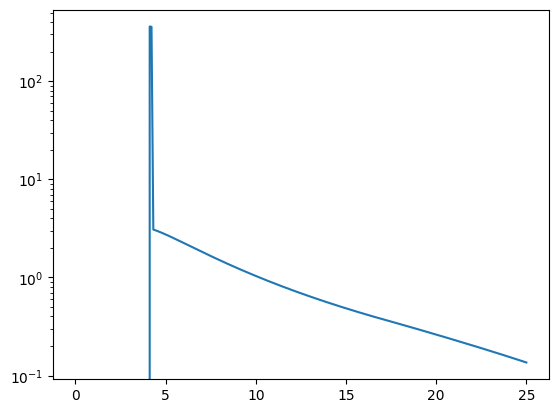

In [9]:
#plot flux through detector linear scale


#"""
x0 = v*4
y0 = Ly/2
z0 = Lz/2
start_time = time.time()
t_max = 25
calc_flux = diff.flux_detector(t_max, 0, y0, z0, x0, y0, z0, 1, 0, 0) #flux_detector(t_max, dev_x1, dev_y1, dev_z1, x0, y0, z0, 1, 0, 0)
t = np.linspace(0,t_max, len(calc_flux))
plt.plot(t, calc_flux)
plt.yscale('log')
print('running time = '+ f'{time.time()-start_time}')
#"""

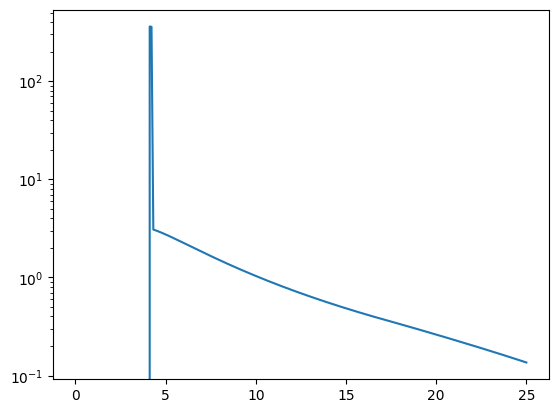

In [10]:
#plot flux through detector log scale


plt.plot(t, calc_flux)
plt.yscale("log")
#plt.savefig("8ns.png")
#calc_flux

In [11]:
#plot 2d sections


from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x0 = 60
y0 = 40
z0 = 20

x = np.arange(0.0,200.0,0.5)
y = np.arange(0.0,200.0,0.5)
X,Y = meshgrid(x, y)

#use multiple processors (might be broken)

"""
A=[]
for i in range(10):
    A.append(0.1+i)
#A = np.array(A)
def draw2d_aux(inst):
    Z = draw2d(inst, x, y) # evaluation of the function on the grid


    im = imshow(Z)#, cmap=plt.colormaps['viridis']) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
    plt.savefig('red_fig'+str(i)+'dif.png')
    plt.clf()
    
    return print("Done ", inst)


   
if __name__ == '__main__':
    pool = Pool()
    pool.map(draw2d_aux, A)
    
"""


"""
for i in range(0,10):
    inst = 0.1+i
    
 # grid of point
    Z = np.log(draw2d(inst, x, y)+1) # evaluation of the function on the grid


    im = imshow(Z, extent=[0,x.max(),0,y.max()], cmap=plt.colormaps['viridis']) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    
    #colorbar(im) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
    plt.savefig('fig'+str(i)+'.png')
    plt.clf()
    print(i)
#"""


"\nfor i in range(0,10):\n    inst = 0.1+i\n    \n # grid of point\n    Z = np.log(draw2d(inst, x, y)+1) # evaluation of the function on the grid\n\n\n    im = imshow(Z, extent=[0,x.max(),0,y.max()], cmap=plt.colormaps['viridis']) # drawing the function\n    # adding the Contour lines with labels\n    #cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)\n    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)\n    \n    #colorbar(im) # adding the colobar on the right\n    # latex fashion title\n    #title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')\n    plt.savefig('fig'+str(i)+'.png')\n    plt.clf()\n    print(i)\n#"

running time = 2474.2188198566437


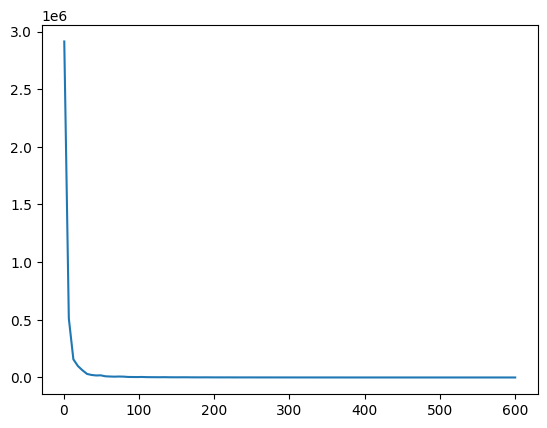

In [12]:
#'''
dist = np.linspace(1, 700, 100, endpoint= True)
total_photons = np.zeros(len(dist))
t_max = 50

def run_points(xxx,yyy,zzz):
    global x0
    x0 = xxx
    global y0
    y0 = yyy
    global z0
    z0 = zzz
    
    return diff.total_flow_detector(t_max, dev_x1, dev_y1, dev_z1, x0, y0, z0, 1, 0, 0)


def pool_handler():
    p = Pool(3)
    global total_photons
    total_photons = p.starmap(run_points, A)
    p.close


    
# number of emission points

n_points=len(dist)

resultsss =[]

for j in range(0,1):

    theta0 = j*15*np.pi/180

    A=[]

    for i in range(n_points):
        A.append([dist[i]*np.cos(theta0)+dev_x1, dist[i]*np.sin(theta0)+dev_y1, dev_z1])



    start_time = time.time()

    if __name__ == '__main__':
        pool_handler()

    print('running time = '+ f'{time.time()-start_time}')
    # [1.8519457570200648, 2.8382830511598685, 0.18448506916005994]
    

"""
start_time = time.time()
for i in range(len(dist)):
    x0 = dist[i]
    efficiency2[i] = total_flow_dif(500)
print('running time = '+ f'{time.time()-start_time}')
"""
plt.plot(dist, total_photons)
#'''

In [ ]:
# Detector size # Andrzej

Lx = 1400#cm

Ly = 365 #cm

Lz = 1200 #cm

# PD size # Andrzej

l = 9.3/2 # square


n = ["number_of_detector"]
x = ["x"]
y = ["y"]
z = ["z"]

a=0

for k in range(3):
    for j in range(3):
        for i in range(21):
            a += 1
            n.append(a)
            x.append(0)
            y.append(l + j*Ly/4)
            z.append(l + k*Lz/4)
import csv
with open('detectors_python.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(n)
    writer.writerow(x)
    writer.writerow(y)
    writer.writerow(z)

for k in range(3):
    for j in range(3):
        for i in range(21):
            a += 1
            n.append(a)
            x.append(0-Lx/2)
            y.append(l + j*Ly/4-Ly/2)
            z.append(l + k*Lz/4-Lz/2)

with open('detectors_G4.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(n)
    writer.writerow(x)
    writer.writerow(y)
    writer.writerow(z)
    
    
n = ["number_of_point"]
x = ["x"]
y = ["y"]
z = ["z"]

a=0

for k in range(3):
    for j in range(3):
        for i in range(20):
            a += 1
            n.append(a)
            x.append(20 * (i + 1))
            y.append(l + j*Ly/4)
            z.append(l + k*Lz/4)

with open('emission_python.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(n)
    writer.writerow(x)
    writer.writerow(y)
    writer.writerow(z)
    
for k in range(3):
    for j in range(3):
        for i in range(20):
            a += 1
            n.append(a)
            x.append(20 * (i + 1) - Lx/2)
            y.append(l + j*Ly/4 - Ly/2)
            z.append(l + k*Lz/4 - Lz/2)
    
with open('emission_G4.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(n)
    writer.writerow(x)
    writer.writerow(y)
    writer.writerow(z)